# Opening data

In [21]:
import pandas as pd

#Opening csv dataset
df1 = pd.read_csv("AMDdata.csv") #AMD
df2 = pd.read_csv("SP500data.csv") #S&P500

#Choosing date and close column from data
df1 = df1[["Date", "Close"]]
df2 = df2[["Date", "Close"]]

# Checking for null values

In [22]:
print(df1["Date"].isnull().sum()) #Summing up null values and counting it
print(df1["Close"].isnull().sum())
print(df2["Date"].isnull().sum())
print(df2["Close"].isnull().sum())
#No null values

0
0
0
0


# Cleaning data

### Formatting date

In [23]:
#format date to DD/MM/YYYY
#AMD
for i in range(len(df1["Date"])):
    current = df1["Date"][i].split("/") #splits original format into month, date, year
    
    if len(current[2]) == 2: #transform year into 4 digits
        current[2] = "20" + current[2]
        
    if current[0][0] == "0": #removes trailing 0 for month
        current[0] = current[0][1:]
    
    new_current = "{}/{}/{}".format(current[1], current[0], current[2]) #formats into DD/MM/YYYY
    
    df1["Date"][i] = new_current #set to current row

In [24]:
#S&P 500
for i in range(len(df2["Date"])):
    current = df2["Date"][i].split("/") #splits original format into date, month, year
    
    if current[1][0] == "0": #removes trailing 0 for month
        current[1] = current[1][1:]
    
    if len(current[2]) <= 2: #transform year into 4 digits
        current[2] = "20" + current[2]
        
    new_current = "{}/{}/{}".format(current[0], current[1], current[2]) #formats into DD/MM/YYYY
         
    df2.loc[i,"Date"] = new_current #set to current row

### Reverse order of S&P500 dataset

In [25]:
new_df2 = pd.DataFrame(columns = df2.columns)
n = len(df2)-1 #backwards selector
m = 0 #counting variable

for i in range(len(df2)):
    if n == 251: #skips 26/11/2019 in S&P500
        n -= 1
        continue
        
    new_df2.loc[m] = [df2["Date"][n], df2["Close"][n]] #reverse order of S&P500 
    
    n -= 1
    m += 1

df2 = new_df2 #set new_df2 into df2

### Numeric casting for close column

In [26]:
#AMD
for i in range(len(df1["Close"])):
    current = df1["Close"][i]
    new_current = round(float(current[1:]), 2) #ignore $ sign and round to 2 d.p.
    
    df1["Close"][i] = new_current
    
df1["Close"] = df1["Close"].astype("float64") #set type of column as float

In [27]:
#S&P
for i in range(len(df2["Close"])):
    current = df2["Close"][i]
    
    new_current = round(current, 2)#round to 2 d.p.
    
    df2.loc[i,"Close"] = new_current

### Combine clean dataset

In [28]:
clean = pd.concat([df1["Date"], df1["Close"], df2["Close"]], axis=1) #join dates and close column of df1 and df2
new_cols = ["Date", "AMD Close", "S&P500 Close"] #create new column names

clean.columns = new_cols #set column names of clean dataset

clean.to_csv("CleanedData.csv", index = False) #create csv file of clean dataset

# Opening clean dataset

In [29]:
df = pd.read_csv("CleanedData.csv") #opening clean dataset

# Analysis

### Summary Statistics

In [30]:
#AMD
summary_statistics = []
statistics_columns = ["Mean", "Median", "Standard Deviation", 
                      "Sample Variance","Kurtosis", 
                      "Skewness", "Range", "Minimum", 
                      "Maximum", "Sum", "Count"] # measures of statistics
for column in df:
    if column == "Date": #skip date
        continue
    current = [] #list holding current statistics
    
    #measures key statistics of column
    current.append(df[column].mean())
    current.append(df[column].median())
    current.append(df[column].std())
    current.append(df[column].var())
    current.append(df[column].kurt())
    current.append(df[column].skew())
    current.append(df[column].max() - df[column].min())
    current.append(df[column].min())
    current.append(df[column].max())
    current.append(df[column].sum())
    current.append(df[column].count())
    
    summary_statistics.append(current)#append statistics of column to list
    
statistics = pd.DataFrame()
for i in range(len(summary_statistics)):
    statistics[df.columns[i+1]] = summary_statistics[i]
statistics.insert(0, "Measure of statistics", statistics_columns)
statistics.set_index("Measure of statistics", inplace = True)

In [31]:
print(statistics)

                         AMD Close   S&P500 Close
Measure of statistics                            
Mean                     27.846375    2859.449044
Median                   28.380000    2887.610000
Standard Deviation        5.187298     154.147725
Sample Variance          26.908058   23761.521124
Kurtosis                 -0.359790       0.319557
Skewness                 -0.057336      -0.783527
Range                    24.640000     782.540000
Minimum                  16.650000    2351.100000
Maximum                  41.290000    3133.640000
Sum                    6989.440000  717721.710000
Count                   251.000000     251.000000


### Correlation and covariance

In [32]:
print("Correlaton matrix")
print("--------------------------------------")
print(clean.corr())

Correlaton matrix
--------------------------------------
              AMD Close  S&P500 Close
AMD Close      1.000000      0.931726
S&P500 Close   0.931726      1.000000


In [33]:
print("Covariance matrix")
print("--------------------------------------")
print(clean.cov())

Covariance matrix
--------------------------------------
               AMD Close  S&P500 Close
AMD Close      26.908058    745.017195
S&P500 Close  745.017195  23761.521124


# Visualisation

### S&P500 vs AMD

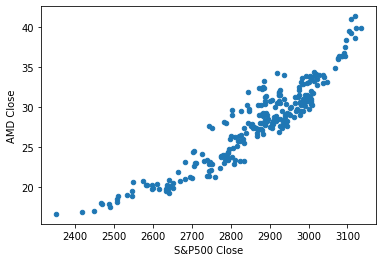

In [34]:
graph = df.plot.scatter(x = "S&P500 Close", y = "AMD Close")

# Building predictive model

### Linear regression model

In [35]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from math import sqrt

import matplotlib.pyplot as plt

X = df["S&P500 Close"]
Y = df["AMD Close"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

regr = linear_model.LinearRegression()
regr.fit(X_train[:,None], Y_train)

print('Coefficients:', regr.coef_)
print('Intercept:', regr.intercept_)

print('-----------------------')
#stats on training data
Y_pred_train = regr.predict(X_train[:,None])
mse_train = metrics.mean_squared_error(Y_train, Y_pred_train)
R_squared_train = metrics.r2_score(Y_train, Y_pred_train)
print('Mean squared error (MSE) on train data:', mse_train)
print('Root mean squared error (RMSE) on train data:', sqrt(mse_train)) #Root mean squared error
print('Coefficient of determination (R^2) on train data:', R_squared_train)


print('-----------------------')
#stats on test data
Y_pred_test = regr.predict(X_test[:,None])
mse_test = metrics.mean_squared_error(Y_test, Y_pred_test) #difference between values predicted and values observed
R_squared_test = metrics.r2_score(Y_test, Y_pred_test) #proportion of the variance for a dependent variable that is explained by an independent variable
print('Mean squared error (MSE) on test data:', mse_test)
print('Root mean squared error (RMSE) on test data:', sqrt(mse_test)) #Root mean squared error
print('Coefficient of determination (R^2) on test data:', R_squared_test)

Coefficients: [0.03178351]
Intercept: -63.1171331594134
-----------------------
Mean squared error (MSE) on train data: 3.387053379912183
Root mean squared error (RMSE) on train data: 1.8403948978173632
Coefficient of determination (R^2) on train data: 0.8611241264167792
-----------------------
Mean squared error (MSE) on test data: 4.1668363348552635
Root mean squared error (RMSE) on test data: 2.041283011945003
Coefficient of determination (R^2) on test data: 0.8834111246790033


In [36]:
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_train).fit()
print(model.summary())

X_test = sm.add_constant(X_test)
model = sm.OLS(Y_test, X_test).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              AMD Close   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     1228.
Date:                Tue, 23 Jun 2020   Prob (F-statistic):           8.04e-87
Time:                        17:12:34   Log-Likelihood:                -405.78
No. Observations:                 200   AIC:                             815.6
Df Residuals:                     198   BIC:                             822.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -63.1171      2.604    -24.238   

/Users/jcbest/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Conclusion of regression statistics

In [37]:
print("88% of total variation in Y test is explained by variation in X")
print("Test RMS is slightly bigger than train RMS.")
print("Able to generalise.")

88% of total variation in Y test is explained by variation in X
Test RMS is slightly bigger than train RMS.
Able to generalise.


### Visualising regression model

In [42]:
print(X_test.shape, Y_test.shape)
plt.scatter(X_test["S&P500", Y_test,  color='black')
plt.plot(X_test, Y_pred_test, color='blue', linewidth=3)
plt.show()

(51, 2) (51,)


# Residual analysis

### Find residuals

In [ ]:
Y_pred = regr.predict(X[:,None])
residual = df["AMD Close"] - Y_pred

### Visualise residuals

In [ ]:
plt.scatter(df["S&P500 Close"],residual)
plt.xlabel("S&P500 Close")
plt.ylabel("Residual")
plt.show()

### Histogram of residual

In [ ]:
plt.hist(residual, density=True, bins=30)
print("Mean: ", residual.mean())
print("Median: ", residual.median())
print("Right skewed")
plt.ylabel('Probability')

### Conclusion of residual analysis

In [ ]:
print("Residual is linear")
print("Residual is independent")
print("Residual is approximately normally distributed")
print("Residual has equal variance")

# Using predictive model

In [ ]:
test = regr.predict([[3270]]) #Dec 2019 S&P500
print(test)